In [1]:
from tqdm import tqdm, trange
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import scipy as sp
import time
import sys
import importlib
import os
import hashlib
import subprocess
import gc

from IPython import display
from IPython.display import clear_output
import copy
from copy import deepcopy
# from sklearn.metrics import roc_auc_score, roc_curve

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset

# from captum.attr import IntegratedGradients
# from captum.attr import LayerConductance
# from captum.attr import NeuronConductance

try:
    import cPickle as pickle
except:
    import pickle
    
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

code_folder1="/home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/"
code_folder2=f"{code_folder1}/prediction_step_0/"

import sys
sys.path.append(code_folder1)
sys.path.append(code_folder2)


energy_folder="/home/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
energy_folder_workstation="/netmount/energy/ykhalak/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file_energy=f"{energy_folder_workstation}/full_ligs.pickle"


all_ligs_db_file_old="/home/ykhalak/Projects/ML_dG/pde2_dG/how_do_ligs_fit_in_pocket/adaptive_learning_test_from_morphed_structs/../processed_ligs_w_morphing_sim_annealing_only_sucessfull.pickle"
experiment_folder="/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF/"
all_ligs_db_file=f"{experiment_folder}/full_ligs.pickle"

datafolder=f"{experiment_folder}/cached_reprs"

# settings_folder=f"{experiment_folder}/combined_repr_search_with_repeats_and_mparam_scan/settings/"
# os.makedirs(settings_folder, exist_ok=True)


Bohr2Ang=0.529177249
RT=0.001985875*300 #kcal/mol


# Import training code

In [13]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

# Define representation blocks

In [3]:
flags_2D=[dataBlocks.MACCS, dataBlocks.Descriptors, dataBlocks.Graph_desc, dataBlocks.BCUT2D]
flags_3D=[dataBlocks.EState_FP, dataBlocks.Pharmacophore_feature_map,
          dataBlocks.MOE, dataBlocks.MQN, dataBlocks.GETAWAY, dataBlocks.AUTOCORR2D,
          dataBlocks.AUTOCORR3D, dataBlocks.WHIM, dataBlocks.RDF,
          dataBlocks.USR, dataBlocks.USRCUT, dataBlocks.PEOE_VSA, dataBlocks.SMR_VSA,
          dataBlocks.SlogP_VSA, dataBlocks.MORSE]

flags_2D_3D=flags_2D+flags_3D

# Prep folder structure

In [ ]:
# ## soft link the ligand database
# #! ln -s $all_ligs_db_file_old $all_ligs_db_file

# # add a dG property to every ligand and save in experiment folder
# with open(all_ligs_db_file_old, 'rb') as f:
#     ligs_expt = pickle.load(f)
    
# for lig in ligs_expt:
#     lig.SetProp( "dG", str(-RT*float(lig.GetProp('[V] hPDE2_pIC50'))*np.log(10)) )
# pickle.dump( ligs_expt, open( all_ligs_db_file, "wb" ) )

# del ligs_expt
# _=gc.collect()

In [23]:
# # make a copy of database on energy
# os.makedirs(energy_folder_workstation, exist_ok=True)
# !cp $all_ligs_db_file $all_ligs_db_file_energy

# load active learner code

In [4]:
#! ln -s /home/ykhalak/Projects/ML_dG/pde2_dG/generators/structures/set_4/morphing_annealing_4d09_filtered_subset/prediction_step_0/utils.py $experiment_folder/utils.py

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

# find how many ligands are there

In [5]:
with open(all_ligs_db_file, 'rb') as f:
    ligs_expt = pickle.load(f)    

n_ligs=len(ligs_expt)

del ligs_expt
_=gc.collect()

# set up learner_settings files

In [6]:
normalize_x=True
shuffle_seed=12345678

#n_Epochs=2000
#hl_w=300
#hl_depth=2

n_Epochs=200
hl_w=20
hl_depth=1

init_learning_rate=5e-3
learning_rate_decay=10000 #order of magnitude in this many epochs
weight_decay=1e-3

normalize_x=True
X_filter=None
impfilt=None

weighted=True
use_dropout=True
shiftY=True

redo=False

sele_rules=[
    SelectionRule.greedy,
    #SelectionRule.narrowing,
]
step_sizes=[10,20,50,100,200,300]
run_name_prefixes=[
    f"step_size_{s}_sele_rule_greedy" for s in step_sizes
]

sele_method_sfiles=[]

starting_method=StartingSelectionMethod.weighted_by_2D_repr

learner_settings_folder=f"{experiment_folder}/size_comparison_AL_settings"
os.makedirs(learner_settings_folder, exist_ok=True)

hl_w='auto'
hl_depth='auto'
n_Epochs=2000

counter=0
unfinished=[]

repeats_fnames=[]
repeats_logfns=[]
step_size_sfiles=[]
for rule_id,n_picks_per_step in enumerate(step_sizes):
    this_step_size_sfiles=[]
    print(f"\n\t{n_picks_per_step}\n")
    for r in range(5):
        run_name=f"{run_name_prefixes[rule_id]}_repeat_{r}"
        if(n_picks_per_step==100):
            run_name=f"sele_rule_greedy_repeat_{r}"
        sele_rule=sele_rules[0]
        starting_ligs_seed=123456+r
        learner_settings=[
            normalize_x, shuffle_seed, n_Epochs, init_learning_rate, learning_rate_decay, weight_decay,
            impfilt, X_filter, weighted, shiftY, use_dropout, sele_rule, starting_method, hl_w, hl_depth,
            starting_ligs_seed,n_picks_per_step,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,run_name
        ]

        sha = hashlib.sha256()
        sha.update(pickle.dumps(learner_settings))
        #settings_hash=dr_name+"_"+sha.hexdigest()[:10]
        #settings_fname=f"{learner_settings_folder}/learner_settings_repr_{settings_hash}.pickle"
        settings_hash=sha.hexdigest()[:6]

        settings_fname=f"{learner_settings_folder}/learner_settings_size_comparison_{run_name}_{settings_hash}.pickle"
        if(os.path.exists(settings_fname)):
            with open(settings_fname, 'rb') as f:
                settings_loaded, learner_metrics = pickle.load(f)
                if(learner_metrics is not None and not redo):
                    n_iter=np.floor(n_ligs/n_picks_per_step)
                    if(len(learner_metrics.top10_found)<n_iter):
                        print(f"{settings_fname} has started but is not finished.")
                        unfinished.append(counter)
                    else:
                        print(f"{settings_fname} has finished.")
                else:
                    print(f"{settings_fname} exists but is not trained yet.")
                    unfinished.append(counter)
        else:
            #pickle.dump( (learner_settings, None), open( settings_fname, "wb" ) )
            unfinished.append(counter)
    #             pass


        repeats_fnames.append(settings_fname)

        os.makedirs(f"{learner_settings_folder}/run_{settings_hash}/", exist_ok=True)
        repeats_logfns.append(f"{learner_settings_folder}/run_{settings_hash}/run_{settings_hash}.log")
        #print(settings_fname)
        
        this_step_size_sfiles.append(settings_fname)
        counter+=1
    step_size_sfiles.append(this_step_size_sfiles)
    


	10

/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_0_9920d0.pickle has started but is not finished.
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_1_4def47.pickle has started but is not finished.
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_2_dded81.pickle has started but is not finished.
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_3_5b6005.pickle has started but is not finished.
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_setting

In [7]:
print(unfinished)
for i in unfinished:
    print(repeats_fnames[i])

[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 19, 24]
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_0_9920d0.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_1_4def47.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_2_dded81.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_3_5b6005.pickle
/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/learner_settings_size_comparison_step_size_10_sele_rule_greedy_repeat_4_51ff

# Launch repeats of active learnerning with different seeds

In [39]:
if 'custom_dataset_modular_with_binning_6EZF' in sys.modules:
    importlib.reload(sys.modules['custom_dataset_modular_with_binning_6EZF'])
else:
    import custom_dataset_modular_with_binning_6EZF
from custom_dataset_modular_with_binning_6EZF import dataBlocks, CustomMolModularDataset

if 'NNs' in sys.modules:
    importlib.reload(sys.modules['NNs'])
else:
    import NNs
from NNs import *

if 'owl_trainer_w_params_general_with_ensemble_summary_model_6EZF' in sys.modules:
    importlib.reload(sys.modules['owl_trainer_w_params_general_with_ensemble_summary_model_6EZF'])
else:
    import owl_trainer_w_params_general_with_ensemble_summary_model_6EZF
from owl_trainer_w_params_general_with_ensemble_summary_model_6EZF import *

if 'active_learner_6EZF' in sys.modules:
    importlib.reload(sys.modules['active_learner_6EZF'])
else:
    import active_learner_6EZF
from active_learner_6EZF import *

In [40]:
class redirect_output(object):
    """context manager for reditrecting stdout/err to files"""


    def __init__(self, stdout='', stderr=''):
        self.stdout = stdout
        self.stderr = stderr

    def __enter__(self):
        self.sys_stdout = sys.stdout
        self.sys_stderr = sys.stderr

        if self.stdout:
            sys.stdout = open(self.stdout, 'w')
        if self.stderr:
            if self.stderr == self.stdout:
                sys.stderr = sys.stdout
            else:
                sys.stderr = open(self.stderr, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout = self.sys_stdout
        sys.stderr = self.sys_stderr

In [ ]:
from multiprocessing import Process, Queue, Pool, TimeoutError, Lock
import dill

global mp_lock;
mp_lock = Lock()

def run_dill_encoded(payload):
    fun, args = dill.loads(payload)
    return fun(*args)
# def my_pool_apply_async(pool, fun, args):
#     payload = dill.dumps((fun, args))
#     return pool.apply_async(run_dill_encoded, (payload,))
def my_pool_map(pool, fun, args_list):
    payloads = [dill.dumps((fun, [arg])) for arg in args_list]
    return pool.map(run_dill_encoded, payloads)

def run_AL_single(A):
    settings_fname, logfn=A
    #print(logfn)
    with redirect_output(logfn):
        #print(settings_fname, logfn)
        #AL_Trainer(settings_fname, all_ligs_db_file, redo=False, verbose=True)
        all_ligs_db_file_cluster=f"{energy_folder}/full_ligs.pickle"
        AL_Trainer(settings_fname, all_ligs_db_file_cluster, redo=True, verbose=True,
                   use_moa=True, iter_through_full_DSet=True, save_Preds=True)



args=list(zip(repeats_fnames,repeats_logfns))
#args=list(zip(repeats_fnames[15:],repeats_logfns[15:]))
#args=[args[i] for i in unfinished]
with Pool(processes=len(args), initargs=(mp_lock,)) as pool:
    my_pool_map(pool, run_AL_single, args)

In [44]:
for A in args[:2]:
    print(A[1])
    run_AL_single(A)

/home/ykhalak/Projects/ML_dG/pde2_dG/retrospective_active_learning_in_6EZF//size_comparison_AL_settings/run_9920d0/run_9920d0.log


KeyboardInterrupt: 

# Plot AL metrics

## single settings versions

In [ ]:
# # load the repeats of the protocol
# AL_repeat_metrics=[]
# for fn in repeats_fnames:
#     with open(fn, 'rb') as f:
#         learner_settings, learner_metrics = pickle.load(f)
#         AL_repeat_metrics.append(learner_metrics)
        
# mgroups=["selected", "unmeasured", "top10", "top50", "top244"]
        
# run_mean_hist=LearningHistory()
# for m in run_mean_hist.metrics_auto:
#     atrname=m+'_'+'XVal'
#     c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
# #     print(c)
#     setattr(run_mean_hist, atrname, np.mean(c, axis=0))
#     setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
    
# #     raise()
    
#     for d in mgroups:
#         for m in run_mean_hist.metrics:
#             atrname=m+'_'+d
#             c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#             setattr(run_mean_hist, atrname, np.mean(c, axis=0))
#             setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))
        
# mgroups=["top10_found", "top50_found", "top244_found"]
# for atrname in mgroups:
#     c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
#     setattr(run_mean_hist, atrname, np.mean(c, axis=0))
#     setattr(run_mean_hist, atrname+"_err", np.std(c, axis=0)/np.sqrt(len(AL_repeat_metrics)))

In [ ]:
# pgroups=["XVal", "selected", "unmeasured", "top10", "top50", "top244"]

# markers=['s','o','x','P','D','v','^','<','>',]
# alpha=0.2

# x=np.arange(len(run_mean_hist.RMSD_XVal))

# n_sub_plots=len(run_mean_hist.metrics)
# fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
# for sp in range(n_sub_plots):
#     plt.sca(axs[sp])
#     #plt.ylim(0,6.0)
#     #plt.xlabel("# known ligands")
#     plt.xlabel("Step")
#     plt.ylabel(run_mean_hist.metrics[sp])
        
#     for cnum in range(len(pgroups)):
#         lw=1.5
#         lbl=pgroups[cnum]
#         ls="solid"
#         if("top" in lbl):
#             ls="dashed"
#         atrname=run_mean_hist.metrics[sp]+'_'+lbl
        
#         if not hasattr(run_mean_hist, atrname+"_err"):
#             continue;
#         y_avg=getattr(run_mean_hist, atrname)
#         y_sem=getattr(run_mean_hist, atrname+"_err")
#         if(len(y_avg)!=len(x)):
#             continue;
#         plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
#         plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
#     plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
        
# plt.suptitle("Active learing on experimental dataset\nOur selection rule", size=20)
# plt.tight_layout(rect=[0, 0.03, 1, 1.01])

# plt.sca(axs[0])
# plt.legend(loc='lower center', bbox_to_anchor=(4, -0.45), ncol=len(pgroups))
# plt.show()

In [ ]:
# pgroups=["top10_found", "top50_found", "top244_found"]
# labels=["top 10", "top 50", "top 244"]

# markers=['s','o','x','P','D','v','^','<','>',]
# alpha=0.2

# x=np.arange(len(run_mean_hist.RMSD_XVal))

# plt.figure(figsize=(6,5), facecolor='w')

# plt.xlabel("Step")
# plt.ylabel("# top ligands found")
    
# for cnum in range(len(pgroups)):
#     lbl=labels[cnum]#pgroups[cnum][:-6]
#     atrname=pgroups[cnum]
#     y_avg=getattr(run_mean_hist, atrname)
#     y_sem=getattr(run_mean_hist, atrname+"_err")
#     plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum+3}", linewidth=lw, alpha=alpha)
#     plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum+3}", marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')

# xlim=plt.gca().get_xlim()
# plt.hlines(10, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(50, xlim[0], xlim[1], colors="black", linestyles='dotted')
# plt.hlines(244, xlim[0], xlim[1], colors="black", linestyles='dotted')

# plt.vlines(2.5, plt.gca().get_ylim()[0], plt.gca().get_ylim()[1], colors="black", linestyles='dotted')
# plt.gca().set_ylim((0,250))
        
# plt.suptitle("Active learing on experimental dataset\nOur selection rule", size=20)
# plt.tight_layout(rect=[0, 0.03, 1, 1.01])

# plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3)
# plt.show()

# Load top 50 experimental ligand ids

In [48]:
with open(all_ligs_db_file, 'rb') as f:
    ligs_expt = pickle.load(f)    

lig_dGs=np.zeros(len(ligs_expt))
for i,lig in enumerate(ligs_expt):
    lig_dGs[i]=float(lig.GetProp('dG'))
print(lig_dGs)

sorted_lig_ids_by_expt_dG=np.argsort(lig_dGs)
print(sorted_lig_ids_by_expt_dG)

del ligs_expt
_=gc.collect()

[-13.38870799 -13.30640036 -13.29268242 ...  -5.48717541  -5.48717541
  -5.07563725]
[   0    1    2 ... 2327 2337 2350]


# direct selection methods comparison plots

In [62]:
# load the repeats of the protocol
sele_method_names=step_sizes
run_mean_hist_by_sele_method=[]
P_per_sele=[]
for sid in range(len(step_sizes)):
    AL_repeat_metrics=[]
    for fn in step_size_sfiles[sid]:
        with open(fn, 'rb') as f:
            learner_settings, learner_metrics = pickle.load(f)
#             print(list(learner_metrics.__dict__.keys()))
#             print(step_sizes[sid])
#             print(learner_metrics.RMSD_XVal)
#             raise()
            AL_repeat_metrics.append(learner_metrics)
    
#     print(list(AL_repeat_metrics[0].__dict__.keys()))
#     raise()

    mgroups=["selected", "unmeasured", "top10", "top50", "top244"]

    
    max_iter=np.max([len(AL_repeat_metrics[i].RMSD_XVal) for i in range(len(AL_repeat_metrics))])
    
    run_mean_hist=LearningHistory()
    for m in run_mean_hist.metrics_auto:
        atrname=m+'_'+'XVal'
        c=np.full((len(AL_repeat_metrics), max_iter), np.nan)
#         c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
        for i in range(len(AL_repeat_metrics)):
            v=getattr(AL_repeat_metrics[i], atrname)
            c[i,:len(v)]=v
#         print(step_sizes[sid], atrname, c)
        setattr(run_mean_hist, atrname, np.nanmean(c, axis=0))
        non_nan_per_iter=np.count_nonzero(~np.isnan(c), axis=0)
#         print(non_nan_per_iter)
        setattr(run_mean_hist, atrname+"_err", np.nanstd(c, axis=0)/np.sqrt(non_nan_per_iter))

#         raise()

        for d in mgroups:
            for m in run_mean_hist.metrics:
                atrname=m+'_'+d
#                 c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
                c=np.full((len(AL_repeat_metrics), max_iter), np.nan)
                for i in range(len(AL_repeat_metrics)):
                    v=getattr(AL_repeat_metrics[i], atrname)
                    c[i,:len(v)]=v
                setattr(run_mean_hist, atrname, np.nanmean(c, axis=0))
                setattr(run_mean_hist, atrname+"_err", np.nanstd(c, axis=0)/np.sqrt(non_nan_per_iter))
                    
#     num_known_ligs_by_repeat=[]
#     for rep in range(len(AL_repeat_metrics)):
#         num_known_ligs=[len(AL_repeat_metrics[rep].step_lig_ids[0])]
#         for step in range(1,len(AL_repeat_metrics[rep].step_lig_ids)-1):
#             num_known_ligs.append(num_known_ligs[-1]+len(AL_repeat_metrics[rep].step_lig_ids[step]))
#         num_known_ligs_by_repeat.append(num_known_ligs)
#     num_known_ligs_by_repeat=np.array(num_known_ligs_by_repeat)
#     run_mean_hist.num_known_ligs_at_step=num_known_ligs_by_repeat.mean(axis=0)
    run_mean_hist.num_known_ligs_at_step=(2+np.arange(max_iter))*step_sizes[sid]
    print(run_mean_hist.num_known_ligs_at_step)

    mgroups=["top10_found", "top50_found", "top244_found"]
    for atrname in mgroups:
#         c=np.array([getattr(AL_repeat_metrics[i], atrname) for i in range(len(AL_repeat_metrics))])
        c=np.full((len(AL_repeat_metrics), max_iter), np.nan)
        for i in range(len(AL_repeat_metrics)):
            v=getattr(AL_repeat_metrics[i], atrname)
            c[i,:len(v)]=v
        setattr(run_mean_hist, atrname, np.nanmean(c, axis=0))
        non_nan_per_iter=np.count_nonzero(~np.isnan(c), axis=0)
        setattr(run_mean_hist, atrname+"_err", np.nanstd(c, axis=0)/np.sqrt(non_nan_per_iter))
        
     
    #top_50_correctly_predicted
    c=np.full((len(AL_repeat_metrics), max_iter), np.nan)
    n=50
    for i in range(len(AL_repeat_metrics)):
        Ps=AL_repeat_metrics[i].Predictions
        for it in range(len(Ps)):
            top_n_pred_ids=np.argsort(Ps[it])[:n]
            common=np.intersect1d(top_n_pred_ids, sorted_lig_ids_by_expt_dG[:n])
            c[i,it]=len(common)
            #if(i==0):
                #print(top_n_pred_ids, common, len(common))
                #print(top_n_pred_ids, Ps[it][top_n_pred_ids])
    atrname=f"top{n}_correctly_predicted"
    setattr(run_mean_hist, atrname, np.nanmean(c, axis=0))
    non_nan_per_iter=np.count_nonzero(~np.isnan(c), axis=0)
    setattr(run_mean_hist, atrname+"_err", np.nanstd(c, axis=0)/np.sqrt(non_nan_per_iter))
#     raise()
    
    
    
    
    # load preds for this sele
    
        
    run_mean_hist_by_sele_method.append(run_mean_hist)
    P_per_sele.append(P_this_sele)

/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/home/ykhalak/soft/anaconda3/envs/python3_ML_v2/lib/python3.6/site-packages/ipykernel_launcher.py:87: RuntimeWarning: Mean of empty slice


[  20   30   40   50   60   70   80   90  100  110  120  130  140  150
  160  170  180  190  200  210  220  230  240  250  260  270  280  290
  300  310  320  330  340  350  360  370  380  390  400  410  420  430
  440  450  460  470  480  490  500  510  520  530  540  550  560  570
  580  590  600  610  620  630  640  650  660  670  680  690  700  710
  720  730  740  750  760  770  780  790  800  810  820  830  840  850
  860  870  880  890  900  910  920  930  940  950  960  970  980  990
 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130
 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270
 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410
 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550
 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690
 1700 1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 1810 1820 1830
 1840 1850 1860 1870 1880 1890 1900 1910 1920 1930 1940 1950 1960 1970
 1980 

### plot top X evaluated

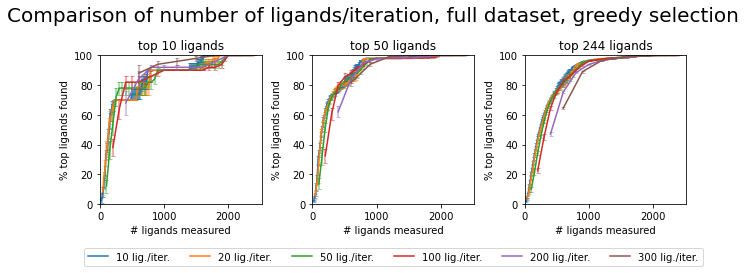

In [10]:
pgroups=["top10_found", "top50_found", "top244_found"]
labels=["top 10", "top 50", "top 244"]
sizes=[10,50,244]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=1.0
alpha_points=0.5

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
fig, axs = plt.subplots(1, n_sub_plots, figsize=[n_sub_plots*3, 1*3+0.5], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    #plt.xlabel("% ligands measured")
    plt.xlabel("# ligands measured")
    plt.ylabel("% top ligands found")
    plt.title(labels[sp]+" ligands")
    
    for cnum in range(len(step_sizes)):
        lbl=f"{step_sizes[cnum]} lig./iter."
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")#*100/2351
        
        ls="solid"
        lw=1.5
        
        plt.plot(x, 100.*y_avg/sizes[sp], linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha, label=lbl)
        #plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
        #             marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k', alpha=alpha_points)
        plt.errorbar(x, 100.*y_avg/sizes[sp], yerr=100.*y_sem/sizes[sp], c=f"C{cnum}",
                     marker="None", capsize=2, linestyle="None", markeredgecolor='k', alpha=alpha_points)

    xlim=plt.gca().get_xlim()
    
#     diag=np.arange(0,100, 2)
#     plt.plot(diag, diag+100*20/2351, ls='dashed', color='grey')

    plt.gca().set_ylim((0,100))
    plt.gca().set_xlim((0,xlim[1]))

    plt.suptitle("Comparison of number of ligands/iteration, full dataset, greedy selection", size=20)
    plt.tight_layout(rect=[0, 0.03, 1, 1.01])

#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=6)

plt.savefig(f"ligs_per_iter_topXfound.png",
                dpi='figure',
                facecolor='w'
               )

plt.show()

## RMSE, KT, top_50

### with top 50 evaluated

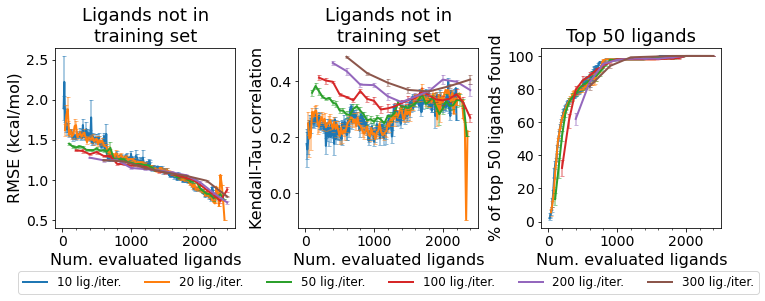

In [52]:
import matplotlib.ticker as ticker

pgroups=["RMSD_unmeasured", "KT_unmeasured", "top50_found"]
labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of top 50 ligands found"]
titles=["Ligands not in\ntraining set", "Ligands not in\ntraining set", "Top 50 ligands"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=1.0
alpha_points=0.5

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.30#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Num. evaluated ligands", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1000))
    axs[sp].xaxis.set_minor_locator(ticker.MultipleLocator(200))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=f"{step_sizes[cnum]} lig./iter."
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")

        
        ls="solid"
        lw=2

#         plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
#         plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
#                      marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha, label=lbl)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker="None", capsize=2, linestyle="None", markeredgecolor='k', alpha=alpha_points)

#     xlim=plt.gca().get_xlim()
#     ylim=plt.gca().get_ylim()
#     plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})

plt.savefig(f"ligs_per_iter_accuracy.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

### with top 50 acording to models instead of evaluated

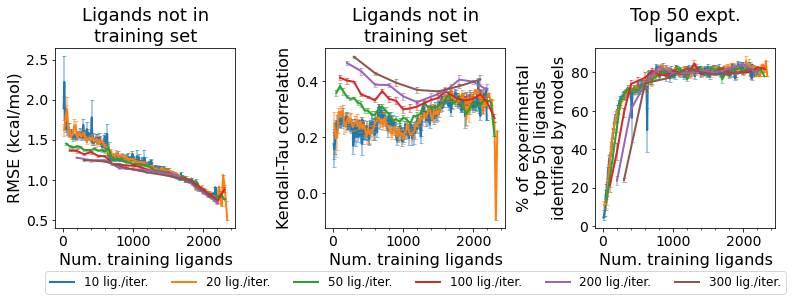

In [64]:
import matplotlib.ticker as ticker

pgroups=["RMSD_unmeasured", "KT_unmeasured", "top50_correctly_predicted"]
labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of experimental\ntop 50 ligands\nidentified by models"]
titles=["Ligands not in\ntraining set", "Ligands not in\ntraining set", "Top 50 expt.\nligands"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=1.0
alpha_points=0.5

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.50#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.30#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Num. training ligands", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1000))
    axs[sp].xaxis.set_minor_locator(ticker.MultipleLocator(200))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=f"{step_sizes[cnum]} lig./iter."
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if("top50" in atrname):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")-step_sizes[cnum]

        
        ls="solid"
        lw=2

#         plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
#         plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
#                      marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha, label=lbl)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker="None", capsize=2, linestyle="None", markeredgecolor='k', alpha=alpha_points)

#     xlim=plt.gca().get_xlim()
#     ylim=plt.gca().get_ylim()
#     plt.gca().set_xlim((xlim[0],xlim[1]))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})

plt.savefig(f"ligs_per_iter_accuracy_v2.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

### per itter picture by Vytas' request

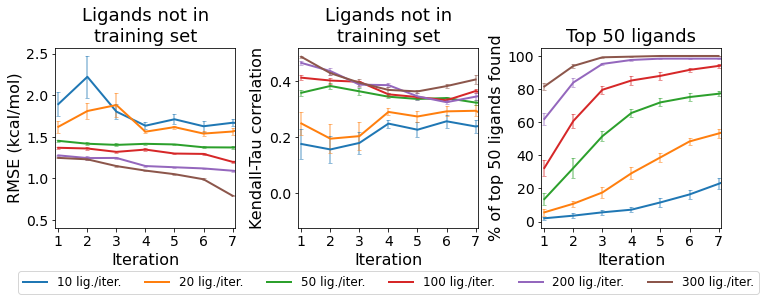

In [13]:
import matplotlib.ticker as ticker

pgroups=["RMSD_unmeasured", "KT_unmeasured", "top50_found"]
labels=["RMSE (kcal/mol)", "Kendall-Tau correlation", "% of top 50 ligands found"]
titles=["Ligands not in\ntraining set", "Ligands not in\ntraining set", "Top 50 ligands"]

markers=['s','o','x','P','D','v','^','<','>',]
alpha=1.0
alpha_points=0.5

# x=np.arange(len(run_mean_hist_by_sele_method[0].RMSD_XVal))
# x=100*7*(x+1)/2351 # convert to percent

n_sub_plots=len(pgroups)
n_sp_x=width=n_sub_plots
n_sp_y=height=1
subp_size=2.5

hspace=0.05#*(height)
wspace=0.35#*(width)

t_pad_factor_h=0.25 #of subp_size
b_pad_factor_h=0.40#0.2 #of subp_size
r_pad_factor_w=0.12#0.05 #of subp_size
l_pad_factor_w=0.30#0.32 #of subp_size
pad_factor_to_cbar=0 #of subp_size
pad_factor_w=(r_pad_factor_w+l_pad_factor_w)*0.5+pad_factor_to_cbar
pad_factor_h=(t_pad_factor_h+b_pad_factor_h)*0.5
fig_h=(height+2*pad_factor_h+(height-1)*hspace)*subp_size
fig_w=(width+2*pad_factor_w+(width-1)*wspace)*subp_size #- 0.6*subp_size

top_pad=t_pad_factor_h*subp_size/fig_h
bot_pad=b_pad_factor_h*subp_size/fig_h
right_pad=r_pad_factor_w*subp_size/fig_w
left_pad=l_pad_factor_w*subp_size/fig_w


fig, axs = plt.subplots(height, width, figsize=[fig_w, fig_h], facecolor='w')
for sp in range(n_sub_plots):
    plt.sca(axs[sp])
    plt.xlabel("Iteration", size=16)
    plt.ylabel(labels[sp], size=16)
    axs[sp].xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.title(titles[sp], size=18)
    
    plt.tick_params(axis='x', labelsize=14 )
    plt.tick_params(axis='y', labelsize=14 )
    
#     if(sp!=0):
#         axs[sp].axes.yaxis.set_ticklabels([])
#         axs[sp].set_ylabel("")

    
    for cnum in range(len(sele_method_names)):
        lbl=f"{step_sizes[cnum]} lig./iter."
        atrname=pgroups[sp]
        y_avg=getattr(run_mean_hist_by_sele_method[cnum], atrname)
        y_sem=getattr(run_mean_hist_by_sele_method[cnum], atrname+"_err")
        
        if(atrname=="top50_found"):
            y_avg=y_avg*100/50
            y_sem=y_sem*100/50
        
        #x=getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")
        x=np.arange(len(getattr(run_mean_hist_by_sele_method[cnum], "num_known_ligs_at_step")))+1

        
        ls="solid"
        lw=2

#         plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha)
#         plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
#                      marker=markers[cnum], capsize=2, linestyle="None", label=lbl, markeredgecolor='k')
        
        plt.plot(x, y_avg, linestyle=ls, c=f"C{cnum}", linewidth=lw, alpha=alpha, label=lbl)
        plt.errorbar(x, y_avg, yerr=y_sem, c=f"C{cnum}",
                     marker="None", capsize=2, linestyle="None", markeredgecolor='k', alpha=alpha_points)

#     xlim=plt.gca().get_xlim()
#     ylim=plt.gca().get_ylim()
    plt.gca().set_xlim((0.9,7.1))
    
    #plt.suptitle("Convergence metrics for top 50 strongest binding ligands", size=20)
    #plt.tight_layout(rect=[0, 0.07, 1, 1])

plt.subplots_adjust(top=1-top_pad, right=1-right_pad, wspace=wspace, hspace=hspace, left=left_pad, bottom=bot_pad)
    
#axs[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=4)
#axs[2].legend(loc='lower center', bbox_to_anchor=(-0.75, -0.32), ncol=5, prop={'size': 12})
if(n_sub_plots%2==0):
    legend_shift=0    
else:
    legend_shift=0.5
axs[int(n_sub_plots/2)].legend(loc='lower center', bbox_to_anchor=(legend_shift, -0.40), ncol=6, prop={'size': 12})

plt.savefig(f"ligs_per_iter_accuracy_limit_to_6_iter.png",
                dpi='figure',
                facecolor='w'
               )
plt.show()

# save collected metrics

In [14]:
pickle.dump( run_mean_hist_by_sele_method, open( "convergence_full_dataset_greedy_different_nligs_per_iter.pickle", "wb" ) )